# Objective
Extract model's spike times on a sliding window of an entire recording

## Setup

In [2]:
%load_ext autoreload
%autoreload 2

# Imports
from tqdm import tqdm
import numpy as np
import torch
from pathlib import Path

import matplotlib.pyplot as plt

from src.model import ModelSpikeSorter
from src import meta

In [3]:
## Set recording

# RECORDING = np.load(SI_MOUSE[2] / "traces.npy", mmap_mode="r")
RECORDING = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/traces.npy", mmap_mode="r")  # already scaled to uV
# RECORDING = np.memmap("/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/patch_rec_cat.si/traces_cached_seg0.raw", dtype="uint16", mode="r", shape=(29231400, 902)).T
# RECORDING = np.load("/data/MEAprojects/primary_mouse/tau/231111/22283/Network/000157/rt_sort/traces.npy", mmap_mode="r")

# RECORDING = np.load("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/traces_unscale_unfilt.npy", mmap_mode="r") # (simulated data, so gain=1)

GAIN_TO_UV = 1

SAMP_FREQ = 30
meta.SAMP_FREQ = SAMP_FREQ  # Needed to prevent some error


In [4]:
## Set model
# Neuropixels model
MODEL = ModelSpikeSorter.load("/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/dl_models/240112/c")

# Organoid model (5118 only had 2 units, so 5118 model has largest training dataset)
# MODEL = ModelSpikeSorter.load("/data/MEAprojects/DLSpikeSorter/models/v0_4_4/5118/230101_135307_305876")

In [5]:
## Set save params
SAVE_ROOT = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/rt_sort")

# SAVE_ROOT = Path("/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/rt_sort")
# SAVE_ROOT = Path("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/rt_sort")

TRACES_PATH = SAVE_ROOT / "traces.npy"
MODEL_OUTPUTS_PATH = SAVE_ROOT / "outputs.npy"  # Path to store model's outputs
WINDOWS_PER_BATCH = 500  # Each window refers to sample of (recording_num_chans, model_sample_size)

## Model on individual windows
Sanity check

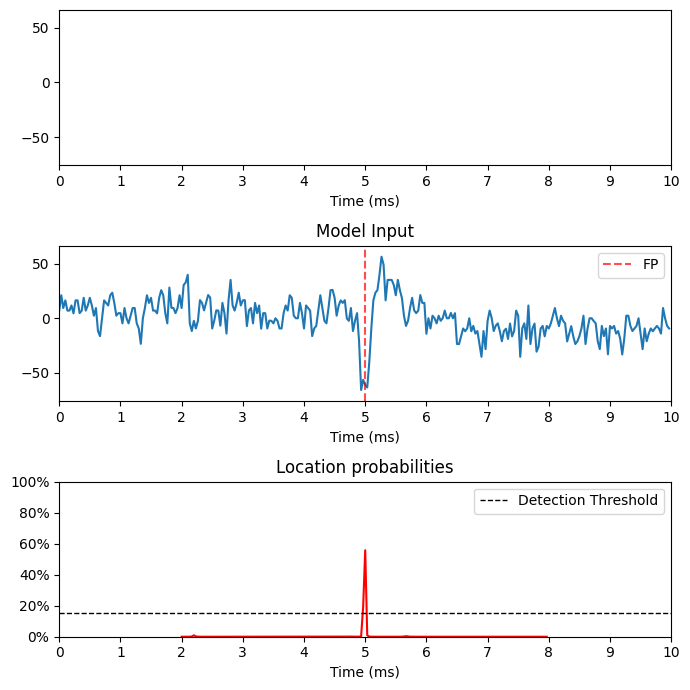

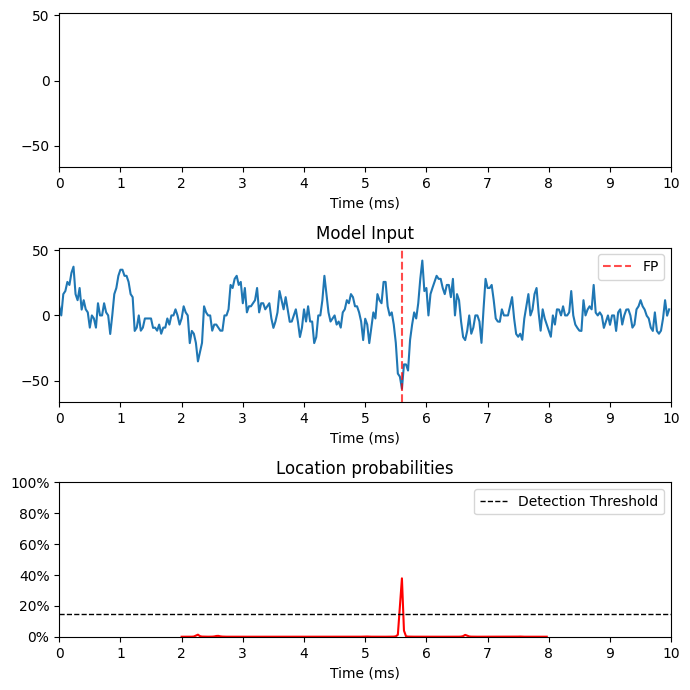

In [6]:
NUM_WINDOWS = 2
np.random.seed(12)
##
count = 0
while count < NUM_WINDOWS:
    channel = np.random.choice(RECORDING.shape[0])
    start_frame = np.random.choice(RECORDING.shape[1]-MODEL.sample_size+1)
    window = RECORDING[channel, start_frame:start_frame+MODEL.sample_size] * GAIN_TO_UV
    # window = window - np.mean(window)
    window = window - np.median(window)
    window = torch.tensor(window[None, None, :], device=MODEL.device, dtype=torch.float16)
    
    with torch.no_grad():
        outputs = MODEL(window).cpu()
    pred = MODEL.outputs_to_preds(outputs)[0]
    
    if len(pred) == 0:
        continue
    
    MODEL.plot_pred(window[0], outputs[0], pred, num_wf=0, wf_labels=None, wf_alphas=None)
    
    count += 1
    
    del window
    del outputs

## Model Predictions (spike times)

### Full run

In [8]:
num_chans, rec_duration = RECORDING.shape

start_frames_all = np.arange(0, rec_duration-MODEL.sample_size+1, MODEL.num_output_locs)

print(f"Allocating memory for recording traces ...")
traces_all = np.zeros_like(RECORDING, dtype="float16")
np.save(TRACES_PATH, traces_all)
traces_all = np.load(TRACES_PATH, mmap_mode="r+")

print("Allocating memory for model outputs ...")
outputs_all = np.zeros((num_chans, start_frames_all.size*MODEL.num_output_locs), dtype="float16")
np.save(MODEL_OUTPUTS_PATH, outputs_all)
outputs_all = np.load(MODEL_OUTPUTS_PATH, mmap_mode="r+")

all_crossings = []  # [(elec_idx, time, amp)]
elec_crossings_ind = [[] for _ in range(num_chans)]  # ith element for elec idx i. Contains ind in all_crossings for elec idx i's crossings
ec_idx = 0

print("Running model ...")
for start_idx in tqdm(range(0, start_frames_all.size, WINDOWS_PER_BATCH)):
    traces = []
    for start_frame in start_frames_all[start_idx:start_idx+WINDOWS_PER_BATCH]:
        trace = RECORDING[:, start_frame:start_frame+MODEL.sample_size] * GAIN_TO_UV
        # trace = trace - np.mean(trace, axis=1, keepdims=True)
        trace = trace - np.median(trace, axis=1, keepdims=True)
        traces.append(trace[:, None, :])
    traces_np = np.vstack(traces).astype("float16")
    traces_torch = torch.tensor(traces_np, device=MODEL.device, dtype=MODEL.dtype)

    with torch.no_grad():
        outputs = MODEL(traces_torch).cpu()
    # del traces_np
    # del traces_torch
    
    batch_preds = []
    batch_chans = []
        
    # region Attempt at optimization. Barely faster (a few minutes for spikeinterface recording)
    # assert False, "Need to test if this actually works properly"
    # from scipy.signal import find_peaks
    # loc_prob_thresh_logit = MODEL.loc_prob_thresh_logit
    # loc_first_frame = MODEL.loc_first_frame
    
    # for i, output in enumerate(outputs):
    #     channel = i % num_chans
    #     idx = start_idx + i // num_chans
    #     start_frame = start_frames_all[idx]

    #     outputs_all[channel, start_frame:start_frame+MODEL.num_output_locs] = output # outputs[i, :]
        
    #     if torch.all(output < loc_prob_thresh_logit):
    #         continue

    #     pred = find_peaks(np.concatenate(((-np.inf,), (output), (-np.inf,))), height=loc_prob_thresh_logit)[0] - 1 + loc_first_frame
    #     pred_ms = (pred + start_frame) / SAMP_FREQ
    #     batch_preds.extend(pred_ms)
    #     batch_chans += [channel] * len(pred_ms)
    # endregion
    
    for i, pred in enumerate(MODEL.outputs_to_preds(outputs)):       
        channel = i % num_chans
        idx = start_idx + i // num_chans
        start_frame = start_frames_all[idx]

        traces_all[channel, start_frame:start_frame+MODEL.sample_size] = traces_np[i, :]
        outputs_all[channel, start_frame:start_frame+MODEL.num_output_locs] = outputs[i, :]

        if pred.size == 0:
            continue

        pred_ms = (pred + start_frame) / SAMP_FREQ
        batch_preds.extend(pred_ms)
        batch_chans += [channel] * len(pred_ms)
                
        # # Testing
        # if i > 300:
        # # if np.abs(amps[0]) < 1:
            
        #     plt.plot(traces_np[i, 0])
        #     plt.axvline(pred[0])
        #     plt.show()
            
        #     fig, ax = plt.subplots(1)
        #     MODEL.plot_loc_probs(outputs[i, :], ax)
        #     plt.show()
        
    order = np.argsort(batch_preds)
    for i in order:
        pred = batch_preds[i]
        chan = batch_chans[i]
        all_crossings.append((chan, pred, -1))
        elec_crossings_ind[chan].append(ec_idx)
        ec_idx += 1

Allocating memory for recording traces ...
Allocating memory for model outputs ...
Running model ...


100%|██████████| 300/300 [33:59<00:00,  6.80s/it]


In [9]:
np.save(SAVE_ROOT / "all_crossings.npy", np.array(all_crossings, dtype=object))
np.save(SAVE_ROOT / "elec_crossings_ind.npy", np.array(elec_crossings_ind, dtype=object))

### Using already made outputs.npy, use different loc_prob_thresh

In [17]:
from scipy.signal import find_peaks
loc_prob_thresh_logit = torch.logit(torch.tensor(17.5)).item()

In [3]:
import numpy as np
np.finfo("float64")

finfo(resolution=1e-15, min=-1.7976931348623157e+308, max=1.7976931348623157e+308, dtype=float64)

In [19]:
assert False, "NOT TESTED TO SEE IF WORKS"

num_chans, rec_duration = RECORDING.shape

start_frames_all = np.arange(0, rec_duration-MODEL.sample_size+1, MODEL.num_output_locs)

outputs_all = np.load(MODEL_OUTPUTS_PATH, mmap_mode="r")

all_crossings = []  # [(elec_idx, time, amp)]
elec_crossings_ind = [[] for _ in range(num_chans)]  # ith element for elec idx i. Contains ind in all_crossings for elec idx i's crossings
ec_idx = 0

print("Getting spike times ...")   
for start_frame in tqdm(start_frames_all):
    batch_preds = []
    batch_chans = []
    for channel in range(num_chans):
        output = outputs_all[channel, start_frame:start_frame+MODEL.num_output_locs]
        pred = find_peaks(np.concatenate(((-np.inf,), (output), (-np.inf,))), height=loc_prob_thresh_logit)[0] - 1 + MODEL.loc_first_frame

        if pred.size == 0:
            continue

        pred_ms = (pred + start_frame) / SAMP_FREQ
        batch_preds.extend(pred_ms)
        batch_chans += [channel] * len(pred_ms)
                
        # # Testing
        # if i > 300:
        # # if np.abs(amps[0]) < 1:
            
        #     plt.plot(traces_np[i, 0])
        #     plt.axvline(pred[0])
        #     plt.show()
            
        #     fig, ax = plt.subplots(1)
        #     MODEL.plot_loc_probs(outputs[i, :], ax)
        #     plt.show()
        
    order = np.argsort(batch_preds)
    for i in order:
        pred = batch_preds[i]
        chan = batch_chans[i]
        all_crossings.append((chan, pred, -1))
        elec_crossings_ind[chan].append(ec_idx)
        ec_idx += 1

Getting spike times ...


  4%|▍         | 9226/224999 [00:56<22:05, 162.74it/s]


KeyboardInterrupt: 

In [ ]:
assert np.all(all_crossings == np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/prop_signal/all_crossings.npy", allow_pickle=True))

In [ ]:
np.save("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/prop_signal/all_crossings_10%.npy", np.array(all_crossings, dtype=object))
np.save("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/prop_signal/elec_crossings_ind_10%.npy", np.array(elec_crossings_ind, dtype=object))

### Save spike times in format for prop signal

In [6]:
# num_chans, rec_duration = RECORDING.shape

# start_frames_all = np.arange(0, rec_duration-MODEL.sample_size+1, MODEL.num_output_locs)

# print("Allocating memory for model outputs ...")
# outputs_all = np.zeros((num_chans, start_frames_all.size*MODEL.num_output_locs), dtype="float16")
# np.save(MODEL_OUTPUTS_PATH, outputs_all)
# outputs_all = np.load(MODEL_OUTPUTS_PATH, mmap_mode="r+")

# spike_times = [[] for _ in range(num_chans)]  # Each element is list of spike times on channel

# # spike_amps not needed for prop/RT-Sort anymore
# # spike_amps = [[] for _ in range(num_chans)]  # Each element is list of amplitudes of spikes on each channel

# print("Running model ...")
# for start_idx in tqdm(range(0, start_frames_all.size, WINDOWS_PER_BATCH)):
#     traces = []
#     for start_frame in start_frames_all[start_idx:start_idx+WINDOWS_PER_BATCH]:
#         trace = RECORDING[:, start_frame:start_frame+MODEL.sample_size]
#         trace = trace - np.mean(trace, axis=1, keepdims=True)
#         traces.append(trace[:, None, :])
#     traces_np = np.vstack(traces).astype("float16")
#     traces_torch = torch.tensor(traces_np, device=MODEL.device, dtype=MODEL.dtype)

#     with torch.no_grad():
#         outputs = MODEL(traces_torch).cpu()
        
#     for i, pred in enumerate(MODEL.outputs_to_preds(outputs)):       
#         channel = i % num_chans
#         idx = start_idx + i // num_chans
#         start_frame = start_frames_all[idx]

#         outputs_all[channel, start_frame:start_frame+MODEL.num_output_locs] = outputs[i, :]

#         if pred.size == 0:
#             continue

#         pred_ms = (pred + start_frame) / SAMP_FREQ
#         spike_times[channel].extend(pred_ms)
        
#         # amps = traces_np[i, 0, pred]
#         # For testing
#         # if i > 300:
#         # # if np.abs(amps[0]) < 1:
            
#         #     plt.plot(traces_np[i, 0])
#         #     plt.axvline(pred[0])
#         #     plt.show()
            
#         #     fig, ax = plt.subplots(1)
#         #     MODEL.plot_loc_probs(outputs[i, :], ax)
#         #     plt.show()
        
#         # assert False
#         # spike_amps[channel].extend(amps)
        
# # MODEL.log("windows_200_120/spike_times.npy", np.array(spike_times, dtype=object))
# # MODEL.log("windows_200_120/spike_amps.npy", np.array(spike_amps, dtype=object))

Allocating memory for model outputs ...
Running model ...


100%|██████████| 2436/2436 [2:05:43<00:00,  3.10s/it]  


In [ ]:
# Test
# import matplotlib.pyplot as plt

# frame = round(908.8333333333334 * SAMP_FREQ)
# traces_np = RECORDING[0, frame-100:frame+100][None, None, :]
# traces_torch = torch.tensor(traces_np, device=MODEL.device, dtype=MODEL.dtype)
# with torch.no_grad():
#     outputs = MODEL(traces_torch).cpu()
# preds = MODEL.outputs_to_preds(outputs)

## Save in correct format for RT-Sort

In [7]:
spike_times = np.load(SAVE_ROOT / "spike_times.npy", allow_pickle=True)
print(f"Total #spikes: {sum(len(s) for s in spike_times)}")

Total #spikes: 8049447


In [9]:
# Reformat cross_times into one long array
all_crossings = []  # [(elec_idx, time, amp)]
elec_crossings_ind = [[] for _ in range(len(spike_times))]  # ith element for elec idx i. Contains ind in all_crossings for elec idx i's crossings

pointers = [0] * len(spike_times)  # Where to index next time in each electrode's crossings (So all_crossings is sorted in time)
for t in tqdm(range(sum((len(t) for t in spike_times)))):
    next_time = np.inf
    next_amp = None
    next_elec = None
    for elec, idx in enumerate(pointers):
        if idx == len(spike_times[elec]):
            continue
        
        time = spike_times[elec][idx]
        if time < next_time:
            next_time = time
            next_amp = -1  # Not using amps anymore # cross_amps[elec][idx]
            next_elec = elec
    
    all_crossings.append((next_elec, next_time, next_amp))
    elec_crossings_ind[next_elec].append(t)
    pointers[next_elec] += 1

100%|██████████| 8049447/8049447 [42:52<00:00, 3129.40it/s]


In [10]:
np.save(SAVE_ROOT / "all_crossings.npy", np.array(all_crossings, dtype=object))
np.save(SAVE_ROOT / "elec_crossings_ind.npy", np.array(elec_crossings_ind, dtype=object))